## Basic Classical Generative Adversarial Networks (Unstructure data)
Reference: https://realpython.com/generative-adversarial-networks/#handwritten-digits-generator-with-a-gan


In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [2]:
# Set the seed for reproducibility
torch.manual_seed(111)

In [3]:
# Use cuda if available
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using device:', device)
    print(torch.cuda.get_device_name(device=device))
    print('Total memory',torch.cuda.get_device_properties(device).total_memory/ 1e9, 'GB')
else:
    device = torch.device("cpu")
    print('Using device:', device)

Using device: cuda
NVIDIA GeForce RTX 4060 Laptop GPU
Total memory 8.585216 GB


# Prepare data

In [4]:
# Prepare the data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
train_set = torchvision.datasets.MNIST(
    root="../../data", train=True, download=True, transform=transform
)

In [5]:
# Create train loader
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

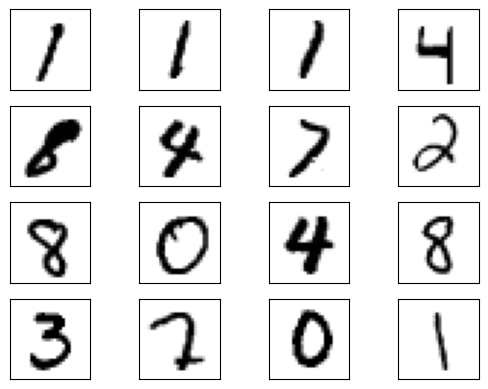

In [6]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

# Create discriminator and generator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output
    
discriminator = Discriminator().to(device=device)

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

# Training module

In [9]:
# Set up
lr = 0.001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [10]:
import os
# Checkpoints folder
checkpoint_folder = '../checkpoints/CGAN_US_checkpoints'

# Ensure the checkpoint folder exists
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)

In [11]:
# Create live plot for training progress
from IPython.display import clear_output

def plot_training_progress(generator_loss_values, discriminator_loss_values, entropy_values):
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy")
    ax2.plot(entropy_values)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()

    plt.show()

In [12]:
# Check if checkpoints exist and load them
discriminator_checkpoint_path = os.path.join(checkpoint_folder, 'discriminator.pth')
generator_checkpoint_path = os.path.join(checkpoint_folder, 'generator.pth')
start_epoch = 0

if os.path.exists(discriminator_checkpoint_path):
    discriminator_checkpoint = torch.load(discriminator_checkpoint_path)
    discriminator.load_state_dict(discriminator_checkpoint['model_state_dict'])
    optimizer_discriminator.load_state_dict(discriminator_checkpoint['optimizer_state_dict'])
    start_epoch = discriminator_checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0

if os.path.exists(generator_checkpoint_path):
    generator_checkpoint = torch.load(generator_checkpoint_path)
    generator.load_state_dict(generator_checkpoint['model_state_dict'])
    optimizer_generator.load_state_dict(generator_checkpoint['optimizer_state_dict'])

Resuming training from epoch 26


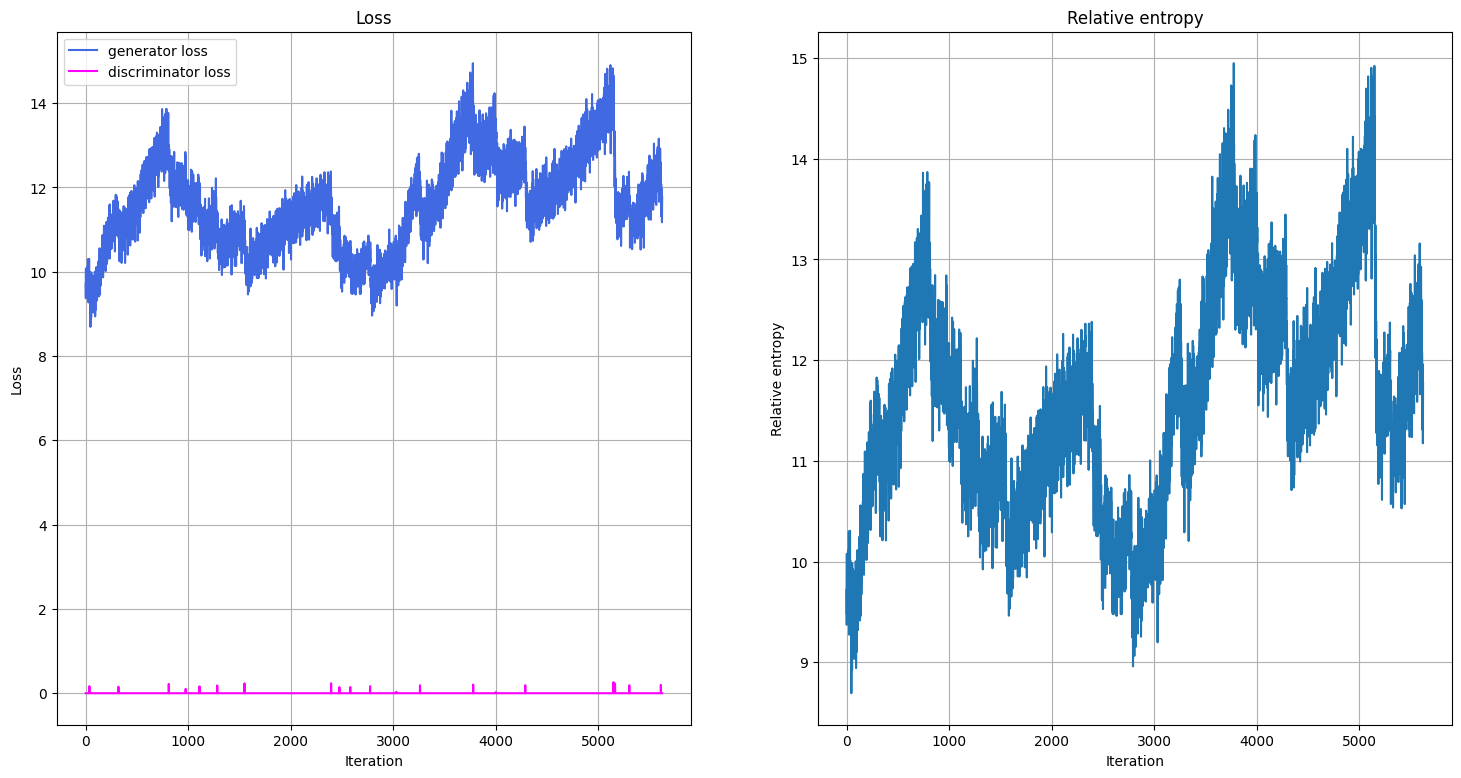

Epoch: 28 Loss D.: 1.378848719468806e-05 Loss G.: 11.771562576293945


In [13]:
generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

for epoch in range(start_epoch, num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Store loss for plotting
        generator_loss_values.append(loss_generator.cpu().detach().numpy())
        discriminator_loss_values.append(loss_discriminator.cpu().detach().numpy())
        entropy_values.append(loss_generator.cpu().detach().numpy() + loss_discriminator.cpu().detach().numpy())
        
    # Show loss
    plot_training_progress(generator_loss_values, discriminator_loss_values, entropy_values)
    print(f"Epoch: {epoch} Loss D.: {loss_discriminator} Loss G.: {loss_generator}")

    # Save Checkpoints for every 10 epoch
    if epoch % 5 == 0:
        
        # Saving the discriminator's state
        discriminator_path = os.path.join(checkpoint_folder, f'discriminator.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': optimizer_discriminator.state_dict(),
            'loss': loss_discriminator.item(),
        }, discriminator_path)

        # Saving the generator's state
        generator_path = os.path.join(checkpoint_folder, f'generator.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': optimizer_generator.state_dict(),
            'loss': loss_generator.item(),
        }, generator_path)




# Post processing and plotting

In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

: 